In [1]:
import numpy as np
import pandas as pd
import shutil
import PIL
import torch
import torchvision
from torchvision.transforms import v2
from torchvision.utils import make_grid
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.nn.modules import Module
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import tqdm.notebook as t
from torchsummary import summary
import copy

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
torch.cuda.is_available()

True

In [3]:
BATCH_SIZE = 1
EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
main_path = './Wonders of World/Wonders of World'
dir_list = os.listdir(main_path)

for num, path in enumerate(dir_list):
    print(f'{path} : {len(os.listdir(os.path.join(main_path, path)))}')

burj_khalifa : 390
chichen_itza : 340
christ_the_reedemer : 323
eiffel_tower : 391
great_wall_of_china : 392
machu_pichu : 393
pyramids_of_giza : 372
roman_colosseum : 394
statue_of_liberty : 238
stonehenge : 204
taj_mahal : 158
venezuela_angel_falls : 251


In [5]:
def get_train_val_image_list(main_path, train_size, val_size):
    train_set = dict()
    val_set = dict()
    
    dir_list = os.listdir(main_path)
    
    for path in t.tqdm_notebook(dir_list):
        file_list = os.listdir(os.path.join(main_path, path))

        total_files = len(file_list)
        train_list = file_list[:train_size]
        val_list = file_list[train_size:train_size+val_size]
        
        train_set[path] = [os.path.join(main_path, path,n) for n in t.tqdm_notebook(train_list)]
        val_set[path] = [os.path.join(main_path, path,n) for n in t.tqdm_notebook(val_list)]
        
        
    return train_set, val_set
    
def get_class_list(train_set):
    idx_to_classes = dict()
    classes_to_idx = dict()
    
    for count, key in enumerate(train_set.keys()):
        idx_to_classes[count] = key
        classes_to_idx[key] = count
        
    return idx_to_classes, classes_to_idx

In [6]:
def copy_files(dirname, dest, img_list):
    if os.path.isdir(os.path.join(dest, dirname)) == False:
        os.mkdir(os.path.join(dest, dirname))
    
    for key, img_path_list in img_list.items():
        if os.path.isdir(os.path.join(dest,dirname, key)) == False:
            os.mkdir(os.path.join(dest,dirname, key))
        for path in img_path_list:
            shutil.copy(path,os.path.join(dest,dirname, key))

In [7]:

def show_images(dataset, num_images=10, images_per_row=5):
    # Get unique labels from the dataset
    unique_labels = set(label for _, label in dataset)
    num_classes = len(unique_labels)
    num_images = min(num_images, num_classes)
    
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 5 * num_rows))
    
    used_labels = set()
    count = 0

    for i in range(len(dataset)):
        if count >= num_images:
            break
        
        img, label = dataset[i]
        
        if label not in used_labels:
            row = count // images_per_row
            col = count % images_per_row
            
            img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C) for displaying
            axes[row, col].imshow(img)
            axes[row, col].set_title(f'Label: {label}')
            axes[row, col].axis('off')
            
            used_labels.add(label)
            count += 1
    
    # Turn off any unused subplots
    for j in range(count, num_rows * images_per_row):
        row = j // images_per_row
        col = j % images_per_row
        axes[row, col].axis('off')
    
    plt.show()

In [8]:
class WoWDataset(Dataset):
    def __init__(self, data, num_classes, transformation =  transforms.Resize(size=(160,160))):
        self.data = data
        self.num_classes = num_classes
        self.transformation = transformation

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, label = self.data[idx]
        return self.transformation(img), label

In [9]:
train_list, val_list = get_train_val_image_list(main_path, train_size=150, val_size=8)
idx_to_classes, classes_to_idx = get_class_list(train_list)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [10]:
classes_to_idx

{'burj_khalifa': 0,
 'chichen_itza': 1,
 'christ_the_reedemer': 2,
 'eiffel_tower': 3,
 'great_wall_of_china': 4,
 'machu_pichu': 5,
 'pyramids_of_giza': 6,
 'roman_colosseum': 7,
 'statue_of_liberty': 8,
 'stonehenge': 9,
 'taj_mahal': 10,
 'venezuela_angel_falls': 11}

In [11]:
train_data = ImageFolder('./Train', transform = ToTensor())
val_data = ImageFolder('./Valid', transform = ToTensor())

In [12]:
train_dataset = WoWDataset(train_data, len(list(idx_to_classes.keys())))
val_dataset = WoWDataset(val_data, len(list(idx_to_classes.keys())))

In [13]:
len(train_dataset)

1800

In [14]:
len(val_dataset)

96

In [15]:
train_dl = DataLoader(train_dataset, BATCH_SIZE, pin_memory=True, shuffle=True)
val_dl =DataLoader(val_dataset, BATCH_SIZE, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.051935498..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009445471..1.0000001].


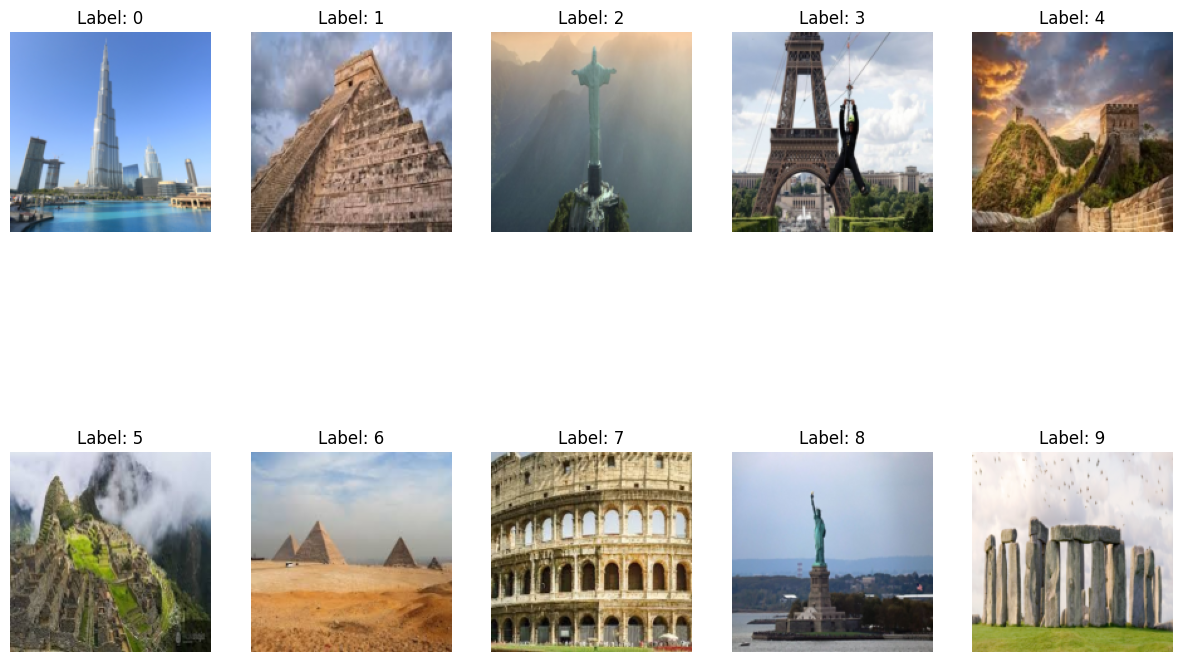

In [16]:
show_images(train_dataset)

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 20 * 20, 512)  # Assuming the input size is 160x160
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 20 * 20)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [19]:
def save_checkpoint(state, is_best, checkpoint_dir='checkpoints', filename='checkpoint.pth.tar'):
    os.makedirs(checkpoint_dir, exist_ok=True)
    filepath = os.path.join(checkpoint_dir, filename)
    torch.save(state, filepath)
    if is_best:
        best_filepath = os.path.join(checkpoint_dir, 'best_model.pth.tar')
        torch.save(state, best_filepath)

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, checkpoint_dir='checkpoints'):
    model.to(device)
    
    # Lists to store loss and accuracy values for each epoch
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    early_stopping = EarlyStopping(patience=5, min_delta=0.01)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_predictions / total_predictions
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_predictions += labels.size(0)
        
        val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct_predictions / val_total_predictions
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
 
        
        # Check if this is the best model so far
        is_best = val_loss == min(val_losses)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_accuracy': train_accuracy,
            'val_accuracy': val_accuracy
        }, is_best, checkpoint_dir=checkpoint_dir)
        
        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    return train_losses, val_losses, train_accuracies, val_accuracies


In [22]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Turn off gradients for validation to save memory and computations
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_loss = val_loss / len(dataloader)
    
    # Compute precision, recall, f1-score
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return avg_loss, precision, recall, f1


In [23]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [24]:
num_classes = len(list(idx_to_classes.keys()))
model = SimpleCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [25]:
# train_model(model, train_dl, val_dl, criterion, optimizer, EPOCHS, DEVICE)
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_dl, val_dl, criterion, optimizer, EPOCHS, DEVICE, checkpoint_dir='checkpoints'
)

Epoch 1/10, Train Loss: 2.0425, Train Accuracy: 0.2961, Val Loss: 1.7453, Val Accuracy: 0.4688
Epoch 2/10, Train Loss: 1.3510, Train Accuracy: 0.5489, Val Loss: 1.4805, Val Accuracy: 0.5208
Epoch 3/10, Train Loss: 0.9342, Train Accuracy: 0.7006, Val Loss: 1.5445, Val Accuracy: 0.5521
Epoch 4/10, Train Loss: 0.5694, Train Accuracy: 0.8228, Val Loss: 1.3682, Val Accuracy: 0.6354
Epoch 5/10, Train Loss: 0.3246, Train Accuracy: 0.9050, Val Loss: 1.5419, Val Accuracy: 0.6042
Epoch 6/10, Train Loss: 0.1647, Train Accuracy: 0.9589, Val Loss: 1.6700, Val Accuracy: 0.6875
Epoch 7/10, Train Loss: 0.1017, Train Accuracy: 0.9700, Val Loss: 1.7250, Val Accuracy: 0.6771
Epoch 8/10, Train Loss: 0.0921, Train Accuracy: 0.9772, Val Loss: 2.0287, Val Accuracy: 0.6979
Epoch 9/10, Train Loss: 0.0597, Train Accuracy: 0.9828, Val Loss: 2.0031, Val Accuracy: 0.6458
Early stopping


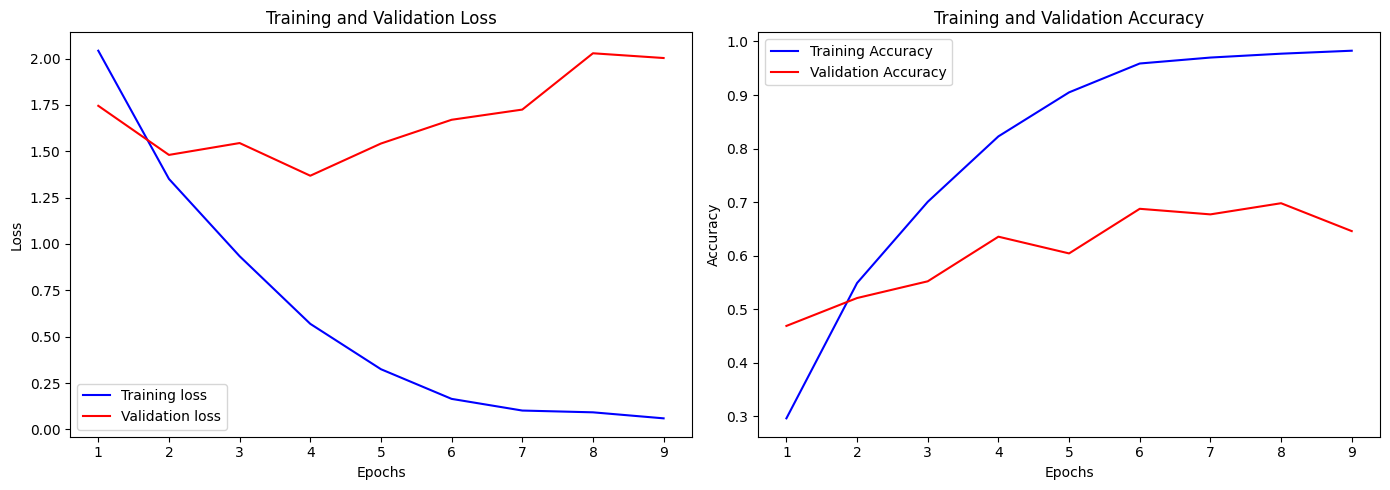

In [26]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [27]:
val_loss, precision, recall, f1 = evaluate_model(model, val_dl, criterion, DEVICE)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Validation Loss: 2.0031
Precision: 0.6677
Recall: 0.6458
F1 Score: 0.6300


In [34]:
tansfomation = transforms.Compose([
    transforms.RandomResizedCrop(size=(160, 160)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15)
])

In [35]:
num_classes = len(list(idx_to_classes.keys()))
model = SimpleCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [36]:
train_dataset_1 = WoWDataset(train_data, len(list(idx_to_classes.keys())),tansfomation)

In [37]:
train_dl_1 = DataLoader(train_dataset_1, BATCH_SIZE, pin_memory=True, shuffle=True)

In [38]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_dl_1, val_dl, criterion, optimizer, EPOCHS, DEVICE, checkpoint_dir='checkpoints'
)

Epoch 1/10, Train Loss: 2.3207, Train Accuracy: 0.1761, Val Loss: 2.0833, Val Accuracy: 0.3542
Epoch 2/10, Train Loss: 2.0187, Train Accuracy: 0.3089, Val Loss: 1.9981, Val Accuracy: 0.3854
Epoch 3/10, Train Loss: 1.9011, Train Accuracy: 0.3706, Val Loss: 1.7507, Val Accuracy: 0.4583
Epoch 4/10, Train Loss: 1.8224, Train Accuracy: 0.3961, Val Loss: 1.7017, Val Accuracy: 0.4375
Epoch 5/10, Train Loss: 1.7449, Train Accuracy: 0.4333, Val Loss: 1.6877, Val Accuracy: 0.4896
Epoch 6/10, Train Loss: 1.6470, Train Accuracy: 0.4717, Val Loss: 1.6600, Val Accuracy: 0.4792
Epoch 7/10, Train Loss: 1.5999, Train Accuracy: 0.4656, Val Loss: 1.5750, Val Accuracy: 0.5104
Epoch 8/10, Train Loss: 1.5133, Train Accuracy: 0.5089, Val Loss: 1.5317, Val Accuracy: 0.5208
Epoch 9/10, Train Loss: 1.4842, Train Accuracy: 0.5278, Val Loss: 1.4122, Val Accuracy: 0.5729
Epoch 10/10, Train Loss: 1.4154, Train Accuracy: 0.5422, Val Loss: 1.3829, Val Accuracy: 0.5312


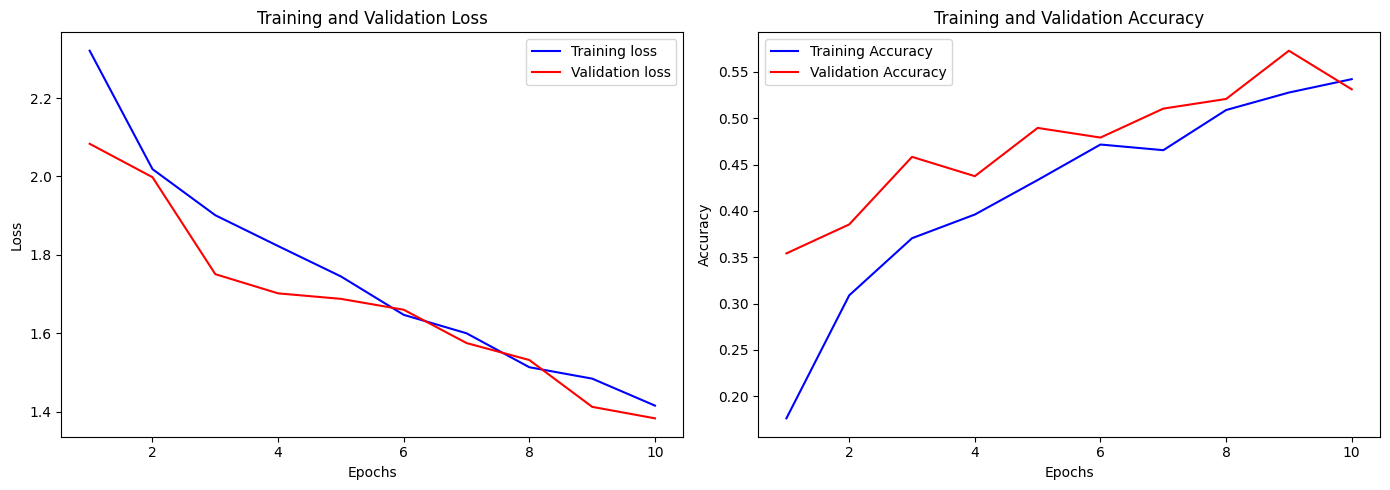

In [39]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [40]:
val_loss, precision, recall, f1 = evaluate_model(model, val_dl, criterion, DEVICE)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Validation Loss: 1.3829
Precision: 0.5180
Recall: 0.5312
F1 Score: 0.5118


In [36]:
from PIL import Image

class AddNoise:
    def __init__(self, noise_type='gaussian', mean=0.0, std=1.0, amount=0.05):
        """
        :param noise_type: Type of noise to add ('gaussian', 'salt_pepper', 'speckle')
        :param mean: Mean for Gaussian noise
        :param std: Standard deviation for Gaussian noise
        :param amount: Proportion of image pixels to be affected by salt-and-pepper noise
        """
        self.noise_type = noise_type
        self.mean = mean
        self.std = std
        self.amount = amount

    def __call__(self, img):
        if isinstance(img, Image.Image):
            img = transforms.ToTensor()(img)
        
        if self.noise_type == 'gaussian':
            noise = torch.randn(img.size()) * self.std + self.mean
            noisy_img = img + noise
        elif self.noise_type == 'salt_pepper':
            noisy_img = self.salt_and_pepper_noise(img, self.amount)
        elif self.noise_type == 'speckle':
            noise = torch.randn(img.size()) * self.std + self.mean
            noisy_img = img + img * noise
        
        noisy_img = torch.clamp(noisy_img, 0, 1)  # Ensure the values are between 0 and 1
        return noisy_img

    def salt_and_pepper_noise(self, img, amount):
        img_np = img.numpy()
        s_vs_p = 0.5
        out = np.copy(img_np)

        # Salt mode
        num_salt = np.ceil(amount * img_np.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img_np.shape]
        out[coords[0], coords[1], :] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * img_np.size * (1.0 - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img_np.shape]
        out[coords[0], coords[1], :] = 0

        return torch.from_numpy(out)

In [28]:
tansfomation = transforms.Compose([
    transforms.RandomResizedCrop(size=(160, 160)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
])

In [29]:
train_dataset_1 = WoWDataset(train_data, len(list(idx_to_classes.keys())),tansfomation)

In [30]:
train_dl_1 = DataLoader(train_dataset_1, BATCH_SIZE, pin_memory=True, shuffle=True)

In [31]:
num_classes = len(list(idx_to_classes.keys()))
model_1 = SimpleCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.0001)

In [32]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model_1, train_dl_1, val_dl, criterion, optimizer, EPOCHS, DEVICE, checkpoint_dir='checkpoints'
)

Epoch 1/10, Train Loss: 2.4035, Train Accuracy: 0.1389, Val Loss: 2.3052, Val Accuracy: 0.1354
Epoch 2/10, Train Loss: 2.1947, Train Accuracy: 0.2333, Val Loss: 2.0284, Val Accuracy: 0.2812
Epoch 3/10, Train Loss: 2.0938, Train Accuracy: 0.2878, Val Loss: 1.9123, Val Accuracy: 0.4167
Epoch 4/10, Train Loss: 2.0151, Train Accuracy: 0.3333, Val Loss: 1.9075, Val Accuracy: 0.3958
Epoch 5/10, Train Loss: 1.9616, Train Accuracy: 0.3356, Val Loss: 1.8310, Val Accuracy: 0.3750
Epoch 6/10, Train Loss: 1.9415, Train Accuracy: 0.3378, Val Loss: 1.7365, Val Accuracy: 0.4479
Epoch 7/10, Train Loss: 1.8739, Train Accuracy: 0.3761, Val Loss: 1.6176, Val Accuracy: 0.4479
Epoch 8/10, Train Loss: 1.8543, Train Accuracy: 0.3794, Val Loss: 1.6111, Val Accuracy: 0.4479
Epoch 9/10, Train Loss: 1.8058, Train Accuracy: 0.3933, Val Loss: 1.6166, Val Accuracy: 0.5000
Epoch 10/10, Train Loss: 1.7817, Train Accuracy: 0.4122, Val Loss: 1.5282, Val Accuracy: 0.4896


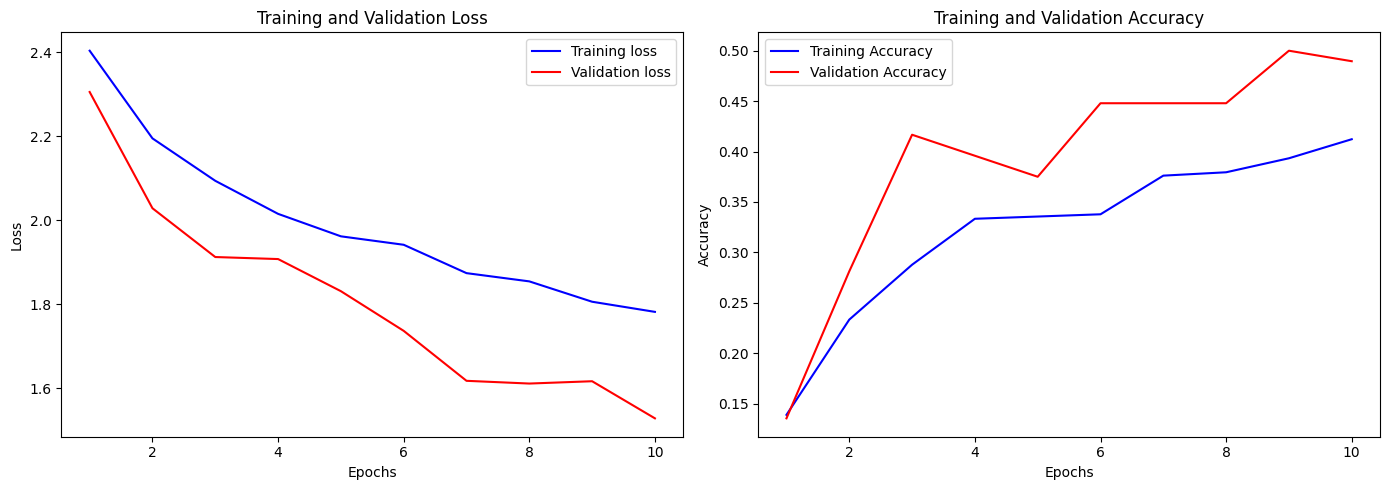

In [33]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [34]:
val_loss, precision, recall, f1 = evaluate_model(model_1, val_dl, criterion, DEVICE)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Validation Loss: 1.5282
Precision: 0.4605
Recall: 0.4896
F1 Score: 0.4536


In [37]:
tansfomation = transforms.Compose([
    transforms.RandomResizedCrop(size=(160, 160)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    AddNoise(noise_type='salt_pepper', mean=0.0, std=0.1, amount=0.05)
])

In [38]:
train_dataset_2 = WoWDataset(train_data, len(list(idx_to_classes.keys())),tansfomation)

In [39]:
train_dl_2 = DataLoader(train_dataset_2, BATCH_SIZE, pin_memory=True, shuffle=True)

In [40]:
num_classes = len(list(idx_to_classes.keys()))
model_2 = SimpleCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.0001)

In [41]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model_2, train_dl_2, val_dl, criterion, optimizer, EPOCHS, DEVICE, checkpoint_dir='checkpoints'
)

Epoch 1/10, Train Loss: 2.4069, Train Accuracy: 0.1428, Val Loss: 2.3882, Val Accuracy: 0.1458
Epoch 2/10, Train Loss: 2.3245, Train Accuracy: 0.1694, Val Loss: 2.2657, Val Accuracy: 0.2188
Epoch 3/10, Train Loss: 2.1878, Train Accuracy: 0.2400, Val Loss: 2.2504, Val Accuracy: 0.1562
Epoch 4/10, Train Loss: 2.0793, Train Accuracy: 0.2939, Val Loss: 2.9466, Val Accuracy: 0.1354
Epoch 5/10, Train Loss: 2.0338, Train Accuracy: 0.3006, Val Loss: 2.7292, Val Accuracy: 0.1458
Epoch 6/10, Train Loss: 1.9662, Train Accuracy: 0.3322, Val Loss: 2.4525, Val Accuracy: 0.1771
Epoch 7/10, Train Loss: 1.9068, Train Accuracy: 0.3578, Val Loss: 2.7379, Val Accuracy: 0.1354
Epoch 8/10, Train Loss: 1.8802, Train Accuracy: 0.3744, Val Loss: 2.7694, Val Accuracy: 0.1667
Early stopping


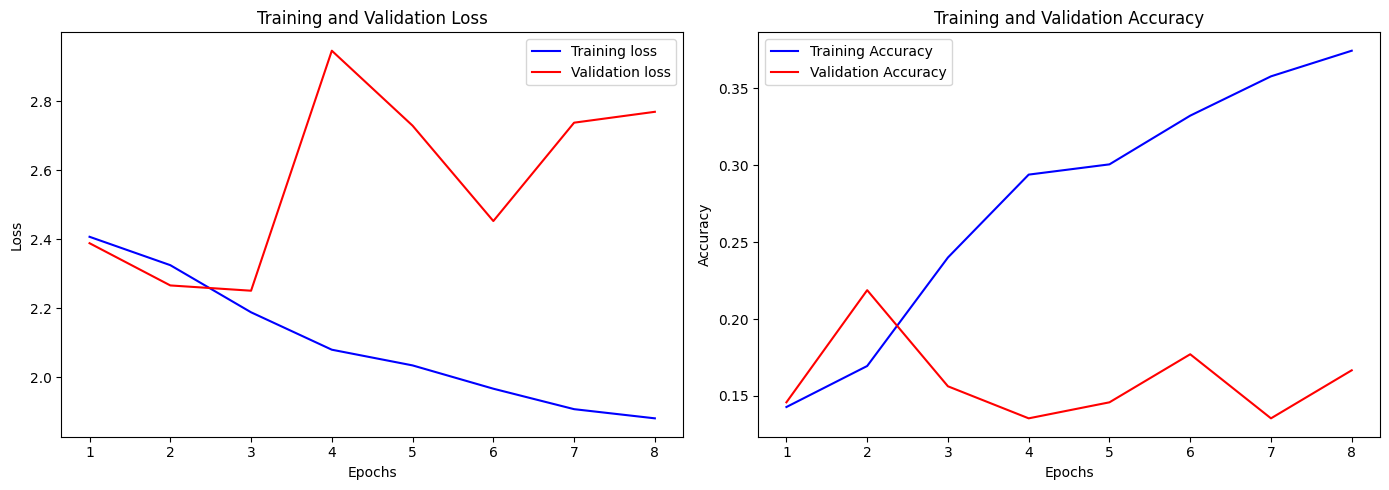

In [42]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [43]:
val_loss, precision, recall, f1 = evaluate_model(model_2, val_dl, criterion, DEVICE)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Validation Loss: 2.7694
Precision: 0.1805
Recall: 0.1667
F1 Score: 0.1066


c:\Users\User\Documents\Master\Predobrada\PrikupljanjeIPredobradaPodatakaZaMasinskoUcenje\.venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
